# Completeness of ocean colour observations for biogeochemical models

Production Date: 02-12-2024  
Produced by: Chiara Volta (ENEA, Italy)

## 🌍 Use case: *Monitoring phytoplankton dynamics in the Southern Ocean*
## ❓ Quality assessment question
**Is chlorophyll-a data sufficiently complete in time and space for integration into biogeochemical models?**

The Ocean Colour dataset version 6.0, as produced for the Copernicus Climate Change Service (C3S), includes the two variables: mass concentration of chlorophyll-a and remote sensing reflectance (Rrs) for six wavelengths from October 1997 to present [[1]](http://dast.data.compute.cci2.ecmwf.int/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_PUGS-of-v6.0-OceanColour-product_v1.1_FINAL.pdf).  
Chlorophyll-a concentration data, which are derived through specific algorithms using remote sensing reflectance (Rrs) [[2]](http://dast.data.compute.cci2.ecmwf.int/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_ATBD-of-v6.0-OceanColour-product_v1.1_FINAL.pdf), are indispensable in biogeochemical modelling as they provide inputs for models initialisation and references to calibrate biogeochemical parameters and validate models results (e.g., [[3]](https://www.sciencedirect.com/science/article/pii/S0924796313000328?via%3Dihub) [[4]](https://www.mdpi.com/2072-4292/10/10/1666) [[5]](https://www.nature.com/articles/s41467-019-08457-x)). Moreover, chlorophyll-a data can be assimilated into models, enabling continuous updates with observed conditions and significantly improve their accuracy (e.g., [[6]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018JC014329)).
The dataset merges measurements carried out by six satellite sensors [[1]](http://dast.data.compute.cci2.ecmwf.int/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_PUGS-of-v6.0-OceanColour-product_v1.1_FINAL.pdf): SeaWiFS, MERIS, MODIS-Aqua, VIIRS, OLCI-3A and OLCI-3B. Each sensor has specific design characteristics and viewing geometry, and no sensor was operational over the whole temporal coverage of the datasets [[1]](http://dast.data.compute.cci2.ecmwf.int/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_PUGS-of-v6.0-OceanColour-product_v1.1_FINAL.pdf) [[2]](http://dast.data.compute.cci2.ecmwf.int/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_ATBD-of-v6.0-OceanColour-product_v1.1_FINAL.pdf). Currently, only OLCI-3A and OLCI-3B are operational.  
Here, the goal is to assess the completeness of the chlorophyll-a dataset at both spatial and temporal scales in the Southern Ocean.

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note
The Ocean Colour dataset version 6.0:
* provides a limited representation of the spatial distribution of chlorophyll-a concentrations in the oceanic region below latitude 45.5°S, based on less than 8% of valid observations.
* provides an acceptable representation of the spatial distribution of chlorophyll-a concentrations off the southeast coast of South America, based on more than 35% of valid observations.
* does not reliably capture temporal chlorophyll-a patterns in the Southern Ocean, due to potential chlorophyll-a overestimation during the austral winter.

* allows for the calculation of monthly chlorophyll-a trends in the Southern Ocean, although these trends should be interpreted with caution as based on less than 14% of valid observations.

## 📋 Methodology

This notebook provides an assessment of the ability of the Ocean Colour dataset version 6.0 to represent the spatial distribution and temporal variability of chlorophyll-a concentrations in the Indian, Pacific, and Atlantic Ocean sectors of the Permanent Open Ocean Zone in the Southern Ocean by analysing the number of valid observations available.
 
The analysis and results are detailed in the sections below:

[](section-1)
   * Import required packages
   * Define parameters to be analysed (time period, variables, regions) and data request

[](section-2)
   * Define transform functions
   * Retrieve data for the selected variables, time period and regions
 
[](section-3)
   * Define mapping function
   * Compute trends 

[](section-4)
   * Display results 
   * Discussion 

## 📈 Analysis and results
(section-1)=
### 1. Choose the data to use and set up the code
#### Import required packages
Besides the standard libraries used to manage and analyse multidimensional arrays, the [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control) `c3s_eqc_automatic_quality_control`is imported to download data and calculate statistics. 

In [21]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.feature as cfeature
import matplotlib.path as mpath
from pymannkendall import original_test
import calendar
import pandas as pd
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
plt.style.use("seaborn-v0_8-notebook")

#### Define parameters to be analysed (time period, variables, regions) and data request
The analysis performed in this notebook examines the spatial and temporal distribution of chlorophyll-a data, and corresponding valid observations, over a 26-year period (January 1998 - December 2023) in three sectors within the oceanic region in the Southern Ocean located between latitudes 47.5°S and 63.5°S (i.e., the Permanent Open Ocean Zone, POOZ) [[7]](https://www.sciencedirect.com/science/article/abs/pii/096706379500021W?via%3Dihub). The three POOZ sectors analysed are: the Indian Ocean sector (IO_POOZ), the Pacific Ocean sector (PO_POOZ) and the Atlantic Ocean sector (AO_POOZ), which extend between longitudes 20°E and 150°E, 150°E and 70°W, and 70°W and 20°E, respectively [[8]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083163).

In [22]:
# Time period
start = "1998-01"
stop = "2023-12"

# Variable
variable = "chlor_a"
assert variable in {"chlor_a"} | {f"Rrs_{wl}" for wl in (443, 560)}

# Regions
regions_monthly = {
    "IO_POOZ": {
        "lon_slice": slice(20, 150),
        "lat_slice": slice(-47.5, -63.5),
    },
    "PO_POOZ": {
        "lon_slice": slice(150, 290),
        "lat_slice": slice(-47.5, -63.5),
    },
    "AO_POOZ": {
        "lon_slice": slice(-70, 20),
        "lat_slice": slice(-47.5, -63.5),
    },
}
regions_map = {
    "SO": {
        "lon_slice": slice(-180, 180),
        "lat_slice": slice(-47.5, -63.5),
    }
}

# Define data request
collection_id = "satellite-ocean-colour"
request = {
    "projection": "regular_latitude_longitude_grid",
    "version": "6_0",
    "format": "zip",
}
chunks = {"year": 1, "month": 1, "variable": 1}

(section-2)=
### 2. Transform functions and data retrieval
#### Define transform functions
The `monthly_weighted_log_mean` function is defined to calculate temporal averages of chlorophyll-a concentration (mg m<sup>-3</sup>) and the percentage of corresponding valid pixels for each POOZ sector by month and year, while the `weighted_log_map` function is defined to compute spatial averages across the entire POOZ.
Both functions account for the varying surface area at different latitudes. Averages for chlorophyll-a concentration are computed using log-transformed daily data, and then back-transformed [[9]](https://doi.org/10.1029/95JC00458). Daily chlorophyll-a concentrations outside the range 0.01-100 mg m<sup>-3</sup> are excluded from the analysis [[10]](https://doi.org/10.3390/s19194285).

In [23]:
def monthly_weighted_log_mean(ds, variable, lon_slice, lat_slice):
    da = ds[variable]
    da = utils.regionalise(da, lon_slice=lon_slice, lat_slice=lat_slice)
    if variable == "chlor_a":
        da = da.where((da > 0.01) & (da < 1.0e2))

    valid_pixels = 100 * da.notnull().groupby("time.year").map(
        diagnostics.monthly_weighted_mean, weights=False
    )
    valid_pixels.attrs = {"long_name": "Valid Pixels", "units": "%"}

    with xr.set_options(keep_attrs=True):
        da = np.log10(da * np.cos(da["latitude"] * np.pi / 180))
        da = 10 ** da.groupby("time.year").map(
            diagnostics.monthly_weighted_mean, weights=False
        )

    ds = xr.merge([da.rename("mean"), valid_pixels.rename("valid_pixels")])
    return ds.mean(["latitude", "longitude"], keep_attrs=True)


def weighted_log_map(ds, variable, lon_slice, lat_slice):
    da = ds[variable]
    da = utils.regionalise(da, lon_slice=lon_slice, lat_slice=lat_slice)
    if variable == "chlor_a":
        da = da.where((da > 0.01) & (da < 1.0e2))

    valid_pixels = 100 * da.notnull().mean("time")
    valid_pixels.attrs = {"long_name": "Valid Pixels", "units": "%"}

    with xr.set_options(keep_attrs=True):
        da = np.log10(da * np.cos(da["latitude"] * np.pi / 180))
        da = 10 ** da.mean("time")
    return xr.merge([da.rename("mean"), valid_pixels.rename("valid_pixels")])

def postprocess(ds):
    ds["mean"].attrs.update({"long_name": "Chl-a", "units": "mg m-3"})
    ds["valid_pixels"].attrs.update({"long_name": "valid observations", "units": "%"})
    return ds

#### Data retrieval
The `monthly_weighted_log_mean` and `regionalised_spatial_weighted_mean` functions are applied to the chlorophyll-a dataset in the selected regions, and temporal and spatial averages are downloaded as two separated arrays.

In [24]:
maps = {}
for region, slices in regions_map.items():
    requests = download.update_request_date(
        request
        | {
            "variable": "remote_sensing_reflectance"
            if variable.startswith("Rrs")
            else "mass_concentration_of_chlorophyll_a"
        },
        start=start,
        stop=stop,
        stringify_dates=True,
    )
    ds = download.download_and_transform(
        collection_id,
        requests,
        transform_func=weighted_log_map,
        transform_func_kwargs=slices | {"variable": variable},
        chunks=chunks,
        transform_chunks=False,
    )
    maps[region] = postprocess(ds)

datasets = []
for region, slices in regions_monthly.items():
    requests = download.update_request_date(
        request
        | {
            "variable": "remote_sensing_reflectance"
            if variable.startswith("Rrs")
            else "mass_concentration_of_chlorophyll_a"
        },
        start=start,
        stop=stop,
        stringify_dates=True,
    )
    ds = download.download_and_transform(
        collection_id,
        requests,
        transform_func=monthly_weighted_log_mean,
        transform_func_kwargs=slices | {"variable": variable},
        chunks=chunks,
        quiet=True,
    )
    datasets.append(postprocess(ds).expand_dims(region=[region]))
ds_monthly = xr.concat(datasets, "region")
ds_monthly = ds_monthly.assign_coords(
    month_abbr=(
        "month",
        [calendar.month_abbr[month] for month in ds_monthly["month"].values],
    )
)

(section-3)=
### 3. Mapping function and trends calculation
#### Define mapping function
The `plot_map` function is defined to visualise the maps of average chlorophyll-a concentrations and corresponding valid observations percentages across the POOZ.

In [25]:
def plot_map(ax, data, lon_data, lat_data, cmap, vmin, vmax, title, cbar_label, central_longitude=0, 
                  add_circle=True, add_labels=True, title_pad=55, extend='both', add_cbar=True):
    cmap = plt.get_cmap(cmap).copy() 
    ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, edgecolor='k', zorder=100)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.coastlines(resolution='50m')
    ax.set_title(title, pad=title_pad, fontsize=30)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder=80)
    gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))
    gl.ylocator = plt.FixedLocator(np.arange(-90, -40 + 1, 10)) 

    pcolor = ax.pcolormesh(lon_data, lat_data, data, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, zorder=90)

    if add_cbar:
        cbar = plt.colorbar(pcolor, ax=ax, orientation='horizontal', pad=0.08, extend=extend)
        cbar.set_label(cbar_label, fontsize=40)  
        cbar.ax.tick_params(labelsize=35) 

    if add_circle:
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)
        
    if add_labels:
        lon_labels = np.arange(-180, 181, 20) 
        for lon in lon_labels:
            if lon == 0:
                label = '0°' 
            elif lon == -180:
                label = '180°'  
            elif lon == 180:
                continue 
            elif lon < 0:
                label = f'{abs(lon)}°W' 
            else:
                label = f'{lon}°E'  
            ax.text(lon, -33, label, transform=ccrs.PlateCarree(),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=25)
        sector_lines = [20, 150, -70] 
    for lon in sector_lines:
        ax.plot([lon, lon], [-90, -40], color='black', transform=ccrs.PlateCarree(), linewidth=3, zorder=110)        
    return ax  

#### Compute trends 
The `calculate_mk_trends` function is defined to calculate chlorophyll-a trends and their statistical significance for each individual month over the 26-year period analysed here in the three POOZ sectors.

In [26]:
def calculate_mk_trends(data):
    result = original_test(data)
    return {"slope": result.slope, "p_value": result.p}

slopes = np.full((len(ds_monthly['region']), len(ds_monthly['month'])), np.nan)
p_values = np.full((len(ds_monthly['region']), len(ds_monthly['month'])), np.nan)

for i, region in enumerate(ds_monthly['region'].values):
    for j, month in enumerate(ds_monthly['month'].values):
        monthly_data = ds_monthly['mean'].sel(region=region, month=month).values
        results = calculate_mk_trends(monthly_data)
        slopes[i, j] = results["slope"]
        p_values[i, j] = results["p_value"]

mk_trends_data = xr.Dataset(
    {
        "slope": (("region", "month"), slopes),
        "p_value": (("region", "month"), p_values)
    },
    coords={"region": ds_monthly['region'].values, "month": ds_monthly['month'].values}
)

(section-4)=
### 4. Display and discuss results
#### Display results
Maps showing the spatial distribution of the percentage of valid observations and the derived chlorophyll-a concentration in the POOZ are provided. Additionally, two sets of heatmaps are generated: the first series shows the monthly chlorophyll-a time series for each POOZ sector by month and year, while the second series displays the corresponding percentage of valid observations. White grid cells in the chlorophyll-a heatmaps indicate missing data. Monthly climatology of valid observations and chlorophyll-a concentrations are also shown. Chlorophyll-a trends and their statistical significance, calculated for each individual month over the 26-year period analysed, are summarized in a table, where statistically significant trends are highlighted in bold. 

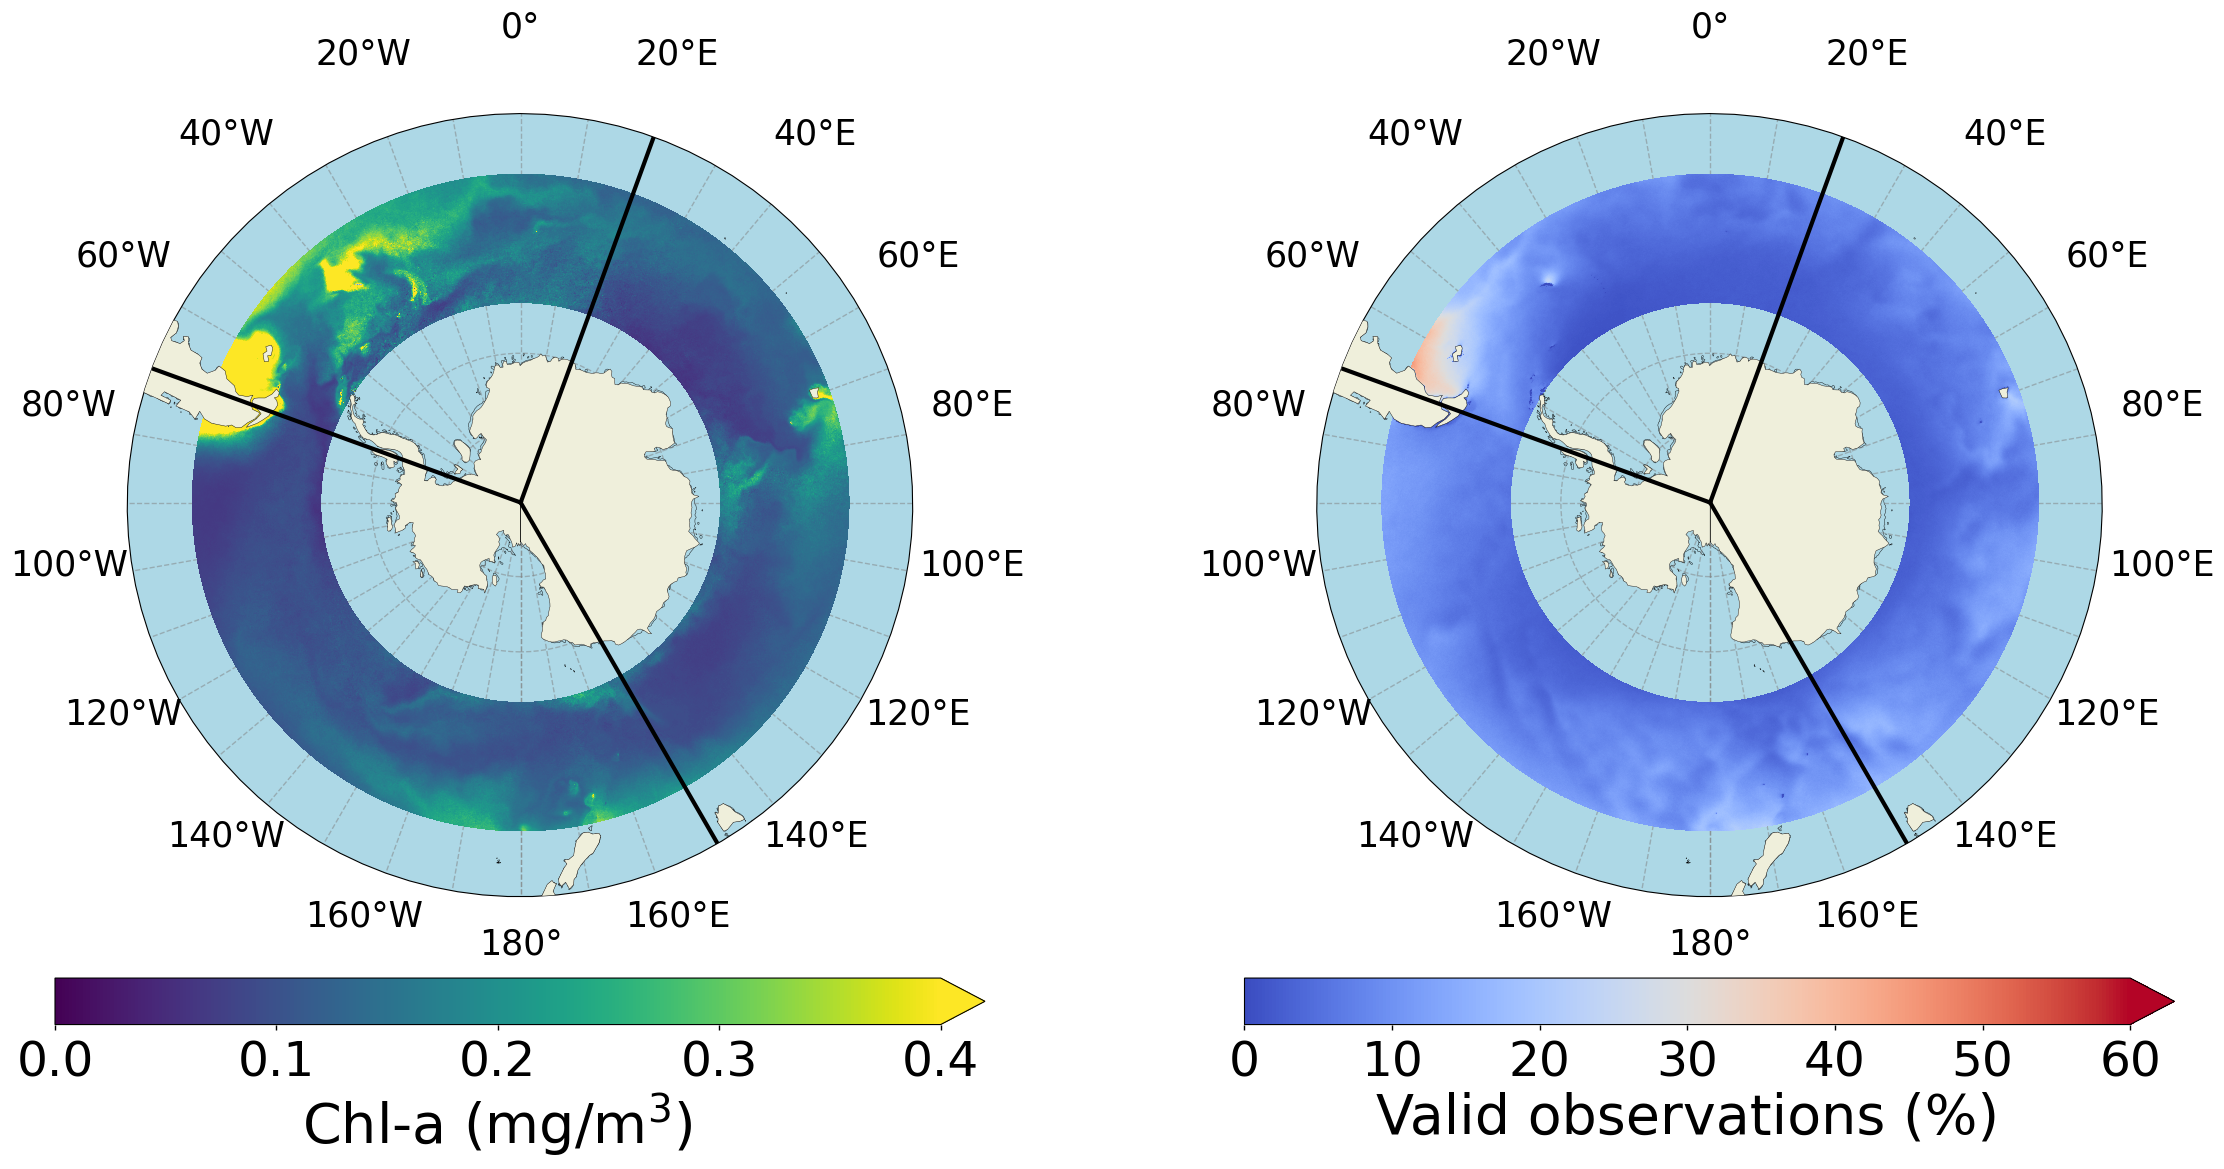

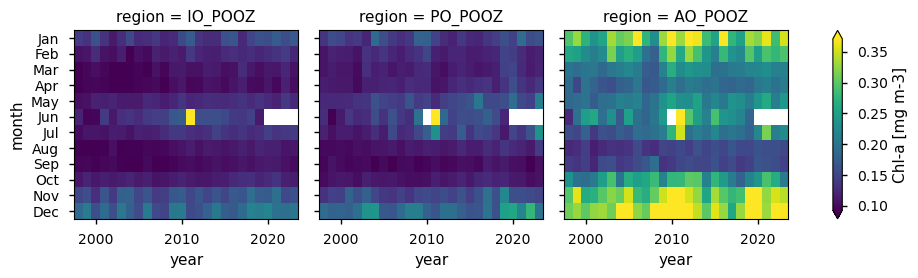

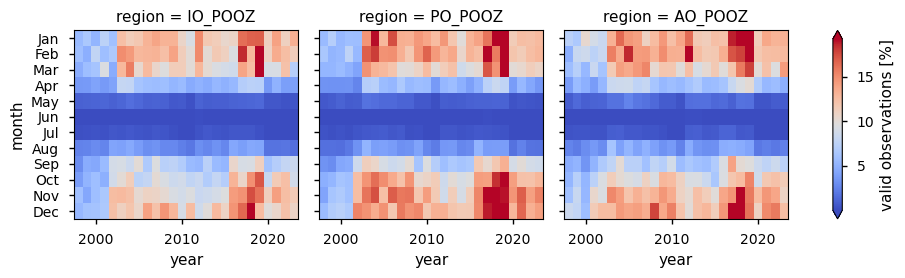

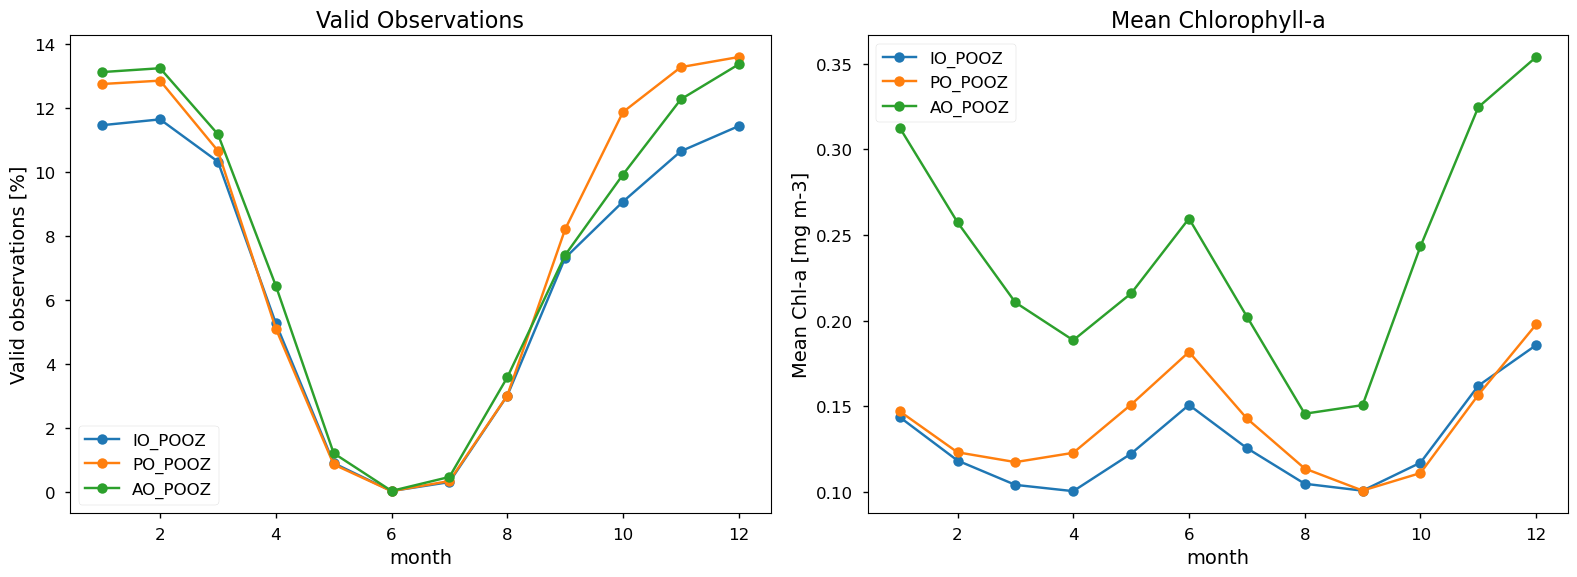

,1,2,3,4,5,6,7,8,9,10,11,12
IO_POOZ,0.0012 (0.0473),0.0011 (0.0002),0.0009 (0.0003),0.0006 (0.0003),0.0008 (0.0001),0.0023 (0.0208),0.0015 (0.0000),0.0011 (0.0000),0.0006 (0.0001),0.0004 (0.0153),0.0008 (0.0343),0.0009 (0.1457)
PO_POOZ,0.0003 (0.5968),0.0003 (0.3321),0.0005 (0.0473),0.0011 (0.0000),0.0017 (0.0001),0.0024 (0.0122),0.0020 (0.0024),0.0012 (0.0000),0.0003 (0.0641),0.0003 (0.0524),0.0007 (0.0641),0.0008 (0.4275)
AO_POOZ,0.0015 (0.2704),0.0014 (0.2011),0.0010 (0.0308),0.0012 (0.0136),0.0021 (0.0004),0.0017 (0.4503),0.0028 (0.0000),0.0015 (0.0000),0.0006 (0.1029),0.0007 (0.5371),0.0018 (0.1457),0.0015 (0.2171)


In [27]:
# Display maps
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 15), subplot_kw={'projection': ccrs.SouthPolarStereo()})
plot_map(ax[0], maps['SO']['mean'], maps['SO']['longitude'], maps['SO']['latitude'],
               cmap='viridis', vmin=0.0, vmax=0.4, title='', cbar_label='Chl-a (mg/m$^3$)', 
              central_longitude=0, add_circle=True, add_labels=True, title_pad=55, 
              extend='max', add_cbar=True)
plot_map(ax[1], maps['SO']['valid_pixels'], maps['SO']['longitude'], maps['SO']['latitude'],
               cmap='coolwarm', vmin=0.0, vmax=60, title='', cbar_label='Valid observations (%)',  
              central_longitude=0, add_circle=True, add_labels=True, title_pad=55, 
              extend='max', add_cbar=True)
plt.tight_layout(rect=[0, 0, 1, 0.75])
plt.show()

# Display heatmaps
for var, da in ds_monthly.data_vars.items():
    facet = da.plot(
        col="region",
        x="year",
        y="month_abbr",
        cmap="coolwarm" if var == "valid_pixels" else "viridis",
        robust=True,
        ylim=(11.5, -0.5),
        xlim=(da["year"].min() - 0.5, da["year"].max() + 0.5),
    )
    facet.set_ylabels("month")
    plt.show()
    
# Display climatologies
plt.rcParams.update({
    'font.size': 14, 
    'axes.titlesize': 16, 
    'axes.labelsize': 14,  
    'legend.fontsize': 12, 
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12,  
})
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
(ds_monthly['valid_pixels'].sel(region='IO_POOZ')).mean(dim='year').plot(
    ax=axes[0], marker=".", label='IO_POOZ', ms=15)
(ds_monthly['valid_pixels'].sel(region='PO_POOZ')).mean(dim='year').plot(
    ax=axes[0], marker=".", label='PO_POOZ', ms=15)
(ds_monthly['valid_pixels'].sel(region='AO_POOZ')).mean(dim='year').plot(
    ax=axes[0], marker=".", label='AO_POOZ', ms=15)
axes[0].legend()
axes[0].set_title('Valid Observations')
axes[0].set_ylabel('Valid observations [%]')
(ds_monthly['mean'].sel(region='IO_POOZ')).mean(dim='year').plot(
    ax=axes[1], marker=".", label='IO_POOZ', ms=15)
(ds_monthly['mean'].sel(region='PO_POOZ')).mean(dim='year').plot(
    ax=axes[1], marker=".", label='PO_POOZ', ms=15)
(ds_monthly['mean'].sel(region='AO_POOZ')).mean(dim='year').plot(
    ax=axes[1], marker=".", label='AO_POOZ', ms=15)
axes[1].legend()
axes[1].set_title('Mean Chlorophyll-a')
axes[1].set_ylabel('Mean Chl-a [mg m-3]')
plt.tight_layout()
plt.show()

# Display mk results
regions = mk_trends_data['region'].values
months = mk_trends_data['month'].values
formatted_data = []
significance_flags = [] 
for i, region in enumerate(regions):
    row = []
    sig_row = []
    for j, month in enumerate(months):
        slope = mk_trends_data['slope'].values[i, j]
        p_value = mk_trends_data['p_value'].values[i, j]
        if p_value <= 0.05: 
            row.append(f"{slope:.4f} ({p_value:.4f})") 
            sig_row.append(True)  
        else:
            row.append(f"{slope:.4f} ({p_value:.4f})")
            sig_row.append(False)
    formatted_data.append(row)
    significance_flags.append(sig_row)
df = pd.DataFrame(formatted_data, index=regions, columns=months)
significance_df = pd.DataFrame(significance_flags, index=regions, columns=months)
def highlight_significant(val, is_significant):
    if is_significant:
        return "font-weight: bold;"
    return ""
styled_table = (
    df.style
    .set_caption("Chlorophyll-a Trends")
    .apply(
        lambda data: significance_df.replace({True: "font-weight: bold;", False: ""}),
        axis=None,
    )
)
styled_table

#### Discussion 

**Chlorophyll-a spatial distribution:**  

The mean availability of chlorophyll-a data over the 26-year period analysed is approximately 7% across the entire POOZ, indicating limited dataset coverage that may not fully capture the spatial variability of chlorophyll-a distribution in this region. A small difference in the number of valid observations is observed across the three POOZ sectors: the PO_POOZ exhibits the greatest availability (8.8%), followed by the AO_POOZ (7.7%) and the IO_POOZ (6.8%). A significant number of valid observations (above 35%) are detected off the southeastern coasts of South America. Therefore, the representation of the spatial distribution of chlorophyll-a in this area can be assumed to be more reliable than elsewhere in the POOZ.  
Different average chlorophyll-a concentrations are observed in the three POOZ sectors: the AO_POOZ sector is the less oligotrophic with an average value of about 0.2 mg m<sup>-3</sup>, whereas the IO_POOZ and PO_POOZ are characterized by lower, but comparable averages (0.12 and 0.13 mg m<sup>-3</sup> in the IO_POOZ and PO_POOZ, respectively), confirming what reported in previous studies (e.g., [[8]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083163)). While the subregional variability in terms of valid observations likely depends on differences in sea ice extent and cloud coverage across the three POOZ sectors, differences in their average chlorophyll-a concentration are influenced by  several key factors, such as nutrient supply through Patagonian dust deposition and/or upwelling (e.g., [[11]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2006jc004072) [[12]](https://tos.org/oceanography/article/patagonian-dust-as-a-source-of-macronutrients-in-the-southwest-atlantic-oce) [[13]](https://www.frontiersin.org/journals/marine-science/articles/10.3389/fmars.2024.1363088/full)).

**Chlorophyll-a temporal distribution:** 

Besides missing data (i.e., white grid cells in the chlorophyll-a heatmap), the average chlorophyll-a concentrations calculated for each individual month over the 26-year period analysed here show surprisingly high isolated values (up to 1.0 mg m<sup>-3</sup>) during the polar night months (i.e., May–July) in all three POOZ sectors. This pattern, which is also observed when analysing the chlorophyll-a monthly climatology, is in contrast to what is typically observed in the Southern Ocean, where the lowest chlorophyll-a concentrations are generally found during the austral winter (e.g., [[14]]( https://www.nature.com/articles/s41467-020-19157-2)). This suggests the presence of a suspicious artefact in the dataset, leading to an overestimation of chlorophyll-a during this period.
Conversely, the monthly climatological distribution of valid chlorophyll-a observations is in line with expectations based on their dependence on the solar zenith angle: the highest percentage (up to about 14%) is observed between November and February, when the solar zenith angle is low, then it decreases to reach its minimum (almost 0%) during the polar night months (i.e. May-July) and gradually increases again towards the end of the year.
It is interesting to note that, as shown in the valid observation heatmap, the valid percentages reveal an initial increase starting in 2002, when MERIS and MODIS-Aqua satellites joined the SeaWiFS mission, and between 2016 and 2020, when the highest number of observation systems were operational (i.e., MODIS-Aqua, VIIRS, OLCI-3A, and OLCI-3B)
([[1]]( http://dast.data.compute.cci2.ecmwf.int/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_PUGS-of-v6.0-OceanColour-product_v1.1_FINAL.pdf)).  
Despite varying statistical significance, the linear trends calculated for each individual month between 1998 and 2023 indicate an overall chlorophyll-a increase across all POOZ sectors examined, consistent with the results of previous studies (e.g., [[8]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083163)). However, these trends should be interpreted with caution as they are based on a percentage of valid observations always below 14%.  
Particular attention should be paid to chlorophyll-a data and trends during the polar night months in the POOZ due to the scarcity of valid observations and the potential chlorophyll-a overestimation.

## ℹ️ If you want to know more

### Key resources
* CDS catalogue entry used in this notebook is the [Ocean colour daily data from 1997 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-ocean-colour?tab=overview)
* Data download is from [CDS](https://cds.climate.copernicus.eu/datasets/satellite-ocean-colour?tab=form)
* Product Documentation is available on the [CDS](https://cds.climate.copernicus.eu/datasets/satellite-ocean-colour?tab=documentation) website  

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [BOpen](https://www.bopen.eu/)

Further readings:
* Ocean Colour Monitoring Portals: [CMEMS](https://marine.copernicus.eu/), [ESA-GlobColour Project](https://hermes.acri.fr), [ESA-OC-CCI](https://climate.esa.int/en/projects/ocean-colour/), [ESA-Sentinel 3](https://sentiwiki.copernicus.eu/web/s3-mission), [IMOS](https://imos.org.au/facility/satellite-remote-sensing/ocean-colour), [NASA](https://oceancolor.gsfc.nasa.gov/#), [NOAA CoastWatch](https://coastwatch.noaa.gov/cwn/index.html)
* Use cases: [EUMETSAT](https://user.eumetsat.int/search-view?sort=startDate%20desc&facets=%7B%22theme%22:%5B%22Marine%7COcean%20biogeochemistry%22%5D,%22contentTypes%22:%5B%22Resources%7CCase%20studies%22%5D%7D), [C3S](https://climate.copernicus.eu/ocean)
* Groom, S., et al. (2019). [Satellite Ocean Colour: Current Status and Future Perspective](https://www.frontiersin.org/journals/marine-science/articles/10.3389/fmars.2019.00485/full). Frontiers in Marine Science, 6.
* [International Ocean Colour Coordinating Group (ICCG)](https://ioccg.org/)

### References

[[1]](http://dast.data.compute.cci2.ecmwf.int/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_PUGS-of-v6.0-OceanColour-product_v1.1_FINAL.pdf) Jackson, T., et al. (2023). C3S Ocean Colour Version 6.0: Product User Guide and Specification. Issue 1.1. E.U. Copernicus Climate Change Service. Document ref. WP2-FDDP-2022-04_C3S2-Lot3_PUGS-of-v6.0-OceanColour-product.  

[[2]](http://dast.data.compute.cci2.ecmwf.int/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_ATBD-of-v6.0-OceanColour-product_v1.1_FINAL.pdf) Jackson, T., et al. (2022). C3S Ocean Colour Version 6.0: Algorithm Theoretical Basis Document. Issue 1.1. E.U. Copernicus Climate Change Service. Document ref. WP2-FDDP-2022-04_C3S2-Lot3_ATBD-of-v6.0-OceanColour-product. 

[[3]](https://www.sciencedirect.com/science/article/abs/pii/S0924796313000328?via%3Dihub) Doron, M., Brasseur, P., Brankart, J.-M., Losa, S.N., & Melet, A. (2013). Stochastic estimation of biogeochemical parameters from Globcolour ocean colour satellite data in a North Atlantic 3D ocean coupled physical–biogeochemical model. Journal of Marine Systems, 117-118, 91-95. 

[[4]](https://www.mdpi.com/2072-4292/10/10/1666) Sammartino, M., Marullo, S., Santoleri, R., & Scardi, M. (2018). Modelling the Vertical Distribution of Phytoplankton Biomass in the Mediterranean Sea from Satellite Data: A Neural Network Approach. Remote Sensing, 10(10), 1666. 

[[5]](https://www.nature.com/articles/s41467-019-08457-x) Dutkiewicz, S., Hickman, A.E., Jahn, O., Henson, S., Beaulieu, C., & Monier, E. (2019) Ocean colour signature of climate change. Nature Communications, 10, 578. 

[[6]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018JC014329) Pradhan, H.K., Völker, C., Losa, S. N., Bracher, A., & Nerger, L. (2019). Assimilation of global total chlorophyll OC-CCI data and its impact on individual phytoplankton fields. Journal of Geophysical Research: Oceans, 124, 470-490. 

[[7]](https://www.sciencedirect.com/science/article/abs/pii/096706379500021W?via%3Dihub) Orsi, A.H., Whitworth, T., & Nowlin, W.D. (1995). On the meridional extent and fronts of the Antarctic Circumpolar Current. Deep Sea Research Part I: Oceanographic Research Papers, 42(5), 641-673.

[[8]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083163) Del Castillo, C.E., Signorini, S.R., Karaköylü, E.M., & Rivero-Calle, S. (2019). Is the Southern Ocean Getting Greener? Geophysical Research Letters, 46, 6034-6040.

[[9]](https://doi.org/10.1029/95JC00458) Campbell, J.W. (1995). The lognormal distribution as a model for bio-optical variability in the sea. Journal of Geophysical Research, 100, 13237-13254.

[[10]](https://doi.org/10.3390/s19194285) Sathyendranath, S., et al. (2019). An Ocean-Colour time series for use in climate studies: the experience of the Ocean-Colour Climate Change Initiative (OC-CCI). Sensors, 19, 4285.

[[11]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2006jc004072) Sokolov, S., & Rintoul, S.R. (2007). On the relationship between fronts of the Antarctic Circumpolar Current and surface chlorophyll concentrations in the Southern Ocean, Journal of Geophysical Research, 112, C07030.

[[12]](https://tos.org/oceanography/article/patagonian-dust-as-a-source-of-macronutrients-in-the-southwest-atlantic-oce) Paparazzo, F.E., Crespi-Abril, A.C., Gonçalves,  R.J., Barbieri, E.S., Gracia Villalobos, L.L., Solís, M.E., & Soria, G. (2018). Patagonian dust as a source of macronutrients in the Southwest Atlantic Ocean. Oceanography, 31(4), 33-39.

[[13]](https://www.frontiersin.org/journals/marine-science/articles/10.3389/fmars.2024.1363088/full) Demasy, C., Boye, M., Lai, B., Burckel, P., Feng, Y., Losno, R., Borensztajn, S., & Besson, P. (2024). Iron dissolution from Patagonian dust in the Southern Ocean: under present and future conditions. Frontiers in Marine Science, 11, 1363088. 

[[14]](https://www.nature.com/articles/s41467-020-19157-2) Arteaga, L.A., Boss, E., Behrenfeld, M.J., Westberr, T.K., & Sarmiento, J.L. (2020). Seasonal modulation of phytoplankton biomass in the Southern Ocean. Nature Communications, 11, 5364.